In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import wave
import IPython.display as ipd # load a local WAV file and PLAY!!!
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import glob

In [2]:
set_a = pd.read_csv('inputsound/set_a.csv')
set_b = pd.read_csv('inputsound/set_b.csv')
set_a_timing = pd.read_csv('inputsound/set_a_timing.csv')
print(f"Shape a = {set_a.shape}")
print(f"Shape b = {set_b.shape}")
print(f"Shape a_timing = {set_a_timing.shape}")

Shape a = (176, 4)
Shape b = (656, 4)
Shape a_timing = (390, 4)


In [3]:
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [4]:
set_b.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [5]:
set_a_timing.head()

,fname,cycle,sound,location
0,set_a/normal__201102081321.wav,1,S1,10021
1,set_a/normal__201102081321.wav,1,S2,20759
2,set_a/normal__201102081321.wav,2,S1,35075
3,set_a/normal__201102081321.wav,2,S2,47244
4,set_a/normal__201102081321.wav,3,S1,62992


### Concat set_a and set-b

In [6]:
train_ab = pd.concat([set_a, set_b])
train_ab.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [7]:
train_ab.isnull().sum()

dataset       0
fname         0
label       247
sublabel    683
dtype: int64

## Labels

In [8]:
train_ab.label.unique()

array(['artifact', 'extrahls', 'murmur', 'normal', nan, 'extrastole'],
      dtype=object)

In [9]:
train_ab.groupby(['label','dataset']).count()

fname  sublabel
label      dataset                 
artifact   a           40         0
extrahls   a           19         0
extrastole b           46         0
murmur     a           34         0
           b           95        29
normal     a           31         0
           b          320       120

Minimum samples per class : 19
Maximum samples per class : 351


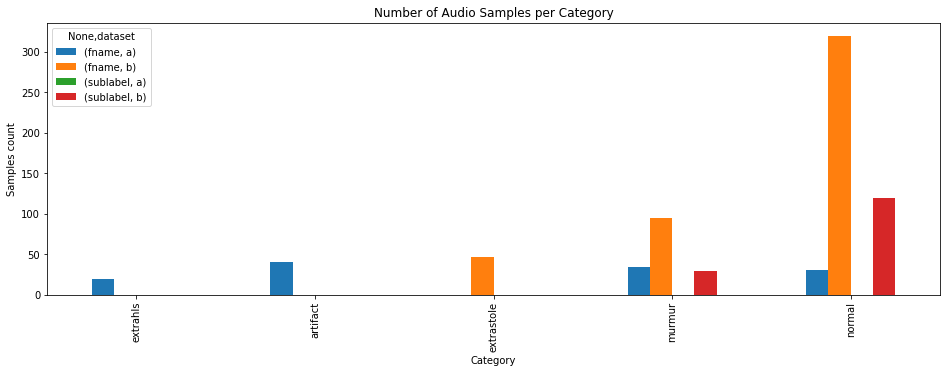

In [10]:
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
        .plot(kind='bar', stacked=False, title="Number of Audio Samples per Category", figsize=(16,5))

plot.set_xlabel('Category')
plot.set_ylabel('Samples count')

print("Minimum samples per class :", min(train_ab.label.value_counts()))
print("Maximum samples per class :",max(train_ab.label.value_counts()));

### Total amount of labeled samples

In [11]:
train_ab.label.value_counts()

normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: label, dtype: int64

In [12]:
train_ab.label.value_counts().sum()

585

##### The are 585 samples of classified data. The rest is NaN, or unlabeled data.

# Normal beats

In [13]:
normal_file = 'inputsound/set_a/normal__201105021654.wav'
ipd.Audio(normal_file)

In [14]:
# WAVFILE
rate, signal = wavfile.read(normal_file)
print("Sampling Rate: ",rate)
print("Total samples: ",signal.shape[0])
print("Duration in:   ",signal.shape[0]/rate,"s")

Sampling Rate:  44100
Total samples:  352677
Duration in:    7.997210884353741 s


In [15]:
#LIBROSA
y, sample_rate = librosa.load(normal_file)
print("Sampling Rate: ",sample_rate)
print("Total samples: ",y.shape[0])
print("Duration in:   ",y.shape[0]/sample_rate,"s")

Sampling Rate:  22050
Total samples:  176339
Duration in:    7.997233560090703 s


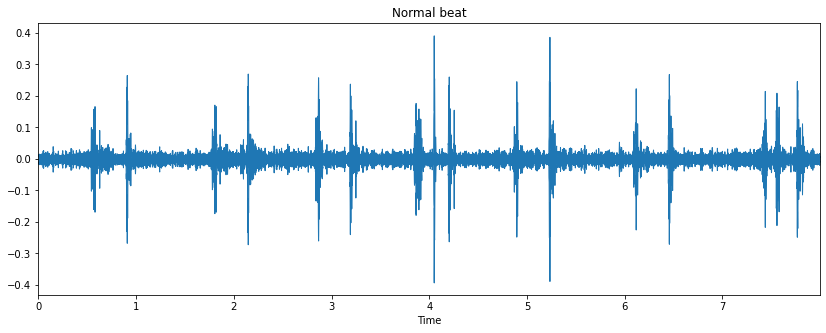

In [16]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y = y, sr=sample_rate)
plt.title("Normal beat");

 # Murmur

In [17]:
murmur_file = 'inputsound/set_a/murmur__201108222236.wav'
ipd.Audio(murmur_file)

In [18]:
y_murmur, sample_rate = librosa.load(normal_file, duration = 4) # cutting duration
dur=librosa.get_duration(y_murmur)
print("Duration in seconds. ",dur)

Duration in seconds.  4.0


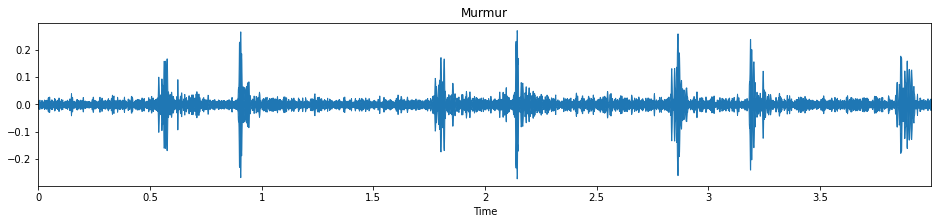

In [19]:
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y = y_murmur, sr=sample_rate)
plt.title("Murmur");

**Same thing for extrasystole, artifact, extra heart sound**

# Beats per minute

``y``|``sample_rate`` will provide a less accurate bpm that ``signal``|``rate``.

This is because the sample rates that librosa and scipy use by defect are different. The standard, is to use 44100Hz as sample rate; however, librosa uses 22050Hz by defect, which means less samples and a little less acurracy, but also less processing time.

In [20]:
# sr = 22050Hz
tempo = librosa.beat.tempo(y = y,sr=sample_rate)
print(tempo)

[123.046875]
